# Importation of packages and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from numpy.linalg import det, inv
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2, norm
from matplotlib.patches import Ellipse, Circle

%matplotlib inline

In [2]:
EM_data = pd.read_csv("EMGaussian.data",sep=" ",names=["X1","X2"])
EM_test = pd.read_csv("EMGaussian.test",sep=" ",names=["X1","X2"])

In [3]:
K = 4
d = 2

# Data vizualisation 

In [4]:
Colors = {0:"red",1:"blue",2:"green",3:"yellow"}

In [5]:
def visualize(data, labels, centr):
    color = [Colors[l] for l in labels]
    plt.scatter(data.X1, data.X2, color=color)
    
    axes = plt.gca()
    axes.set_xlim([data.X1.min()-1,data.X1.max()+1])
    axes.set_ylim([data.X2.min()-1,data.X2.max()+1])
    plt.axis('equal')
    
    plt.scatter(centr.T.X1, centr.T.X2, color="black")

In [6]:
def vizualise_circles(data, labels, centr, sigmas):
    color = [Colors[l] for l in labels]
    plt.scatter(data.X1, data.X2, color=color)

    origin = np.array([0,1])
    ellipses_plot = plt.subplot()
    for k in range(K):
        ellipse = Circle(mu[k],norm.ppf(0.9)*np.sqrt(sigmas[k]),fill=False)
        ellipses_plot.add_artist(ellipse)
        
    plt.scatter(centr.T.X1, centr.T.X2, color="black")

    axes = plt.gca()
    axes.set_xlim([data.X1.min()-1,data.X1.max()+1])
    axes.set_ylim([data.X2.min()-1,data.X2.max()+1])
    plt.axis('equal')
    plt.show()

In [7]:
def vizualise_ellipses(data, labels, centr, cov):
    color = [Colors[l] for l in labels]
    plt.scatter(data.X1, data.X2, color=color)

    origin = np.array([0,1])
    ellipses_plot = plt.subplot()
    for k in range(K):
        ev = np.linalg.eig(cov[k])[0]
        EV = np.linalg.eig(cov[k])[1]
        angle = np.degrees(np.arccos(origin.dot(EV[1])))

        ellipse = Ellipse((mu[k]), 2*np.sqrt(chi2.ppf(0.9, 2)*ev[0]), 2*np.sqrt(chi2.ppf(0.9, 2)*ev[1]), angle,fill=False)
        ellipses_plot.add_artist(ellipse)
        
    plt.scatter(centr.T.X1, centr.T.X2, color="black")

    axes = plt.gca()
    axes.set_xlim([data.X1.min()-1,data.X1.max()+1])
    axes.set_ylim([data.X2.min()-1,data.X2.max()+1])
    plt.axis('equal')
    plt.show()

# K-means

In [8]:
def error_kmeans(data,nbClusters,labels,centroids):
    err = 0
    for k in range(nbClusters):
        err = err + ((data[labels == k] - centroids[k])**2).sum(1).sum()
    return err/data.index.size

In [9]:
def kmeans(data, nbClusters, graph):
    # Initialization step
    init_idx = random.sample(range(1, data.index.size), K)
    centroids = data.T[init_idx]
    centroids.columns = range(nbClusters)
    centroids_old = centroids+1 # To make it different from "centroids"
    
    while ((centroids_old.equals(centroids)) == False):
        centroids_old = centroids.copy()

        # Assignment to closest centroid
        Distances = pd.DataFrame()
        for k in range(nbClusters):
            Dist_to_k = ((data - centroids[k])**2).sum(axis=1)
            Dist_to_k.name = k
            Distances = pd.concat([Distances,Dist_to_k],axis=1)
            
        data_labels = Distances.idxmin(1)

        # Computation of new centroids
        for k in range(nbClusters):
            centroids[k] = data[data_labels == k].mean()

    if graph:
        visualize(data,data_labels,centroids)
        
    return centroids, data_labels

In [10]:
centroids, data_labels = kmeans(data=EM_data, nbClusters=K, graph=False)

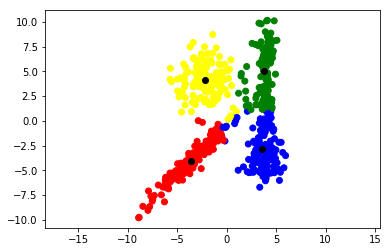

In [11]:
visualize(EM_data,data_labels,centroids)

In [12]:
error_kmeans(EM_data,K,data_labels,centroids)

6.481186049491023

In [47]:
err = {}
for i in range(1000):
    centroids, data_labels = kmeans(data=EM_data, nbClusters=K, graph=False)
    err[i] = error_kmeans(EM_data,K,data_labels,centroids)
pd.Series(err).describe()

count    1000.000000
mean        6.541558
std         0.625532
min         6.475337
25%         6.475559
50%         6.480347
75%         6.481186
max        12.768531
dtype: float64

In [49]:
Case1 = pd.Series(err)[pd.Series(err) < 10]

In [50]:
Case2 = pd.Series(err)[pd.Series(err) > 10]

In [51]:
Case1.describe()

count    990.000000
mean       6.478721
std        0.002596
min        6.475337
25%        6.475559
50%        6.480347
75%        6.481186
max        6.482566
dtype: float64

In [52]:
Case2.describe()

count    10.000000
mean     12.762356
std       0.005314
min      12.758240
25%      12.758240
50%      12.758240
75%      12.768531
max      12.768531
dtype: float64

# Gaussian mixture model

## Useful functions

In [15]:
def gauss(x,mu,Sigma,dim):
    C_norm = 1/np.sqrt(((2*np.pi)**dim)*det(Sigma))
    
    temp = (x-mu).dot(inv(Sigma))
    if len(x.shape) > 1:
        temp.columns = x.columns
        exponent = temp.mul(x-mu).sum(1)
    else:
        exponent = temp.dot(x-mu)

    return C_norm*np.exp(-0.5*exponent)

In [16]:
mu = np.array([0,0])
x = np.array([0,0])

## Covariance matrices proportional to identity

In [17]:
# Data
x = EM_data

# Initialization of parameters with K-means
centroids, data_labels = kmeans(data=EM_data, nbClusters=K, graph=False)

# A posteriori on z given x
q = pd.DataFrame(0,index=x.index, columns=range(K))
for k in range(K):
    q[k] = (data_labels == k).astype(int)

# Parameters to estimate
mu = pd.DataFrame(index=x.columns, columns=range(K))
sigma2 =  pd.Series(index=range(K))
pi = pd.Series(index=range(K))
for k in range(K):
    mu[k] = x.mul(q[k],axis=0).sum()/q[k].sum()
    sigma2[k] = ((x-mu[k])**2).sum(1).mul(q[k],axis=0).sum()/q[k].sum()
    pi[k] = q[k].sum()/q.sum().sum()
    
# Set them different from the actual values
mu_old = mu+1
sigma2_old = sigma2+1
pi_old = pi+1

In [18]:
niter = 0

while ((mu_old.equals(mu) == False) | (sigma2_old.equals(sigma2) == False) | (pi_old.equals(pi) == False)):
    niter = niter + 1
    
    mu_old = mu.copy()
    sigma2_old = sigma2.copy()
    pi_old = pi.copy()
    
    # Expectation step
    denom = pd.Series(0,index=x.index)
    for k in range(K):
        denom = denom + pi[k]*gauss(x,mu[k],sigma2[k]*np.identity(2),2)
        
    for k in range(K):
        q[k] = pi[k]*gauss(x,mu[k],sigma2[k]*np.identity(2),2)/denom

    # Maximization step
    for k in range(K):
        mu[k] = x.mul(q[k],axis=0).sum()/q[k].sum()
        sigma2[k] = 0.5*((x-mu[k])**2).sum(1).mul(q[k],axis=0).sum()/q[k].sum()
        pi[k] = q[k].sum()/q.sum().sum()

print("Iterations :", niter)

Iterations : 357


In [21]:
Sigma = {}
for k in range(K):
    Sigma[k] = sigma2[k]*np.identity(2)

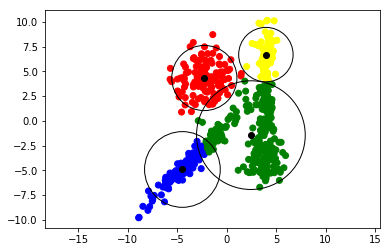

In [22]:
vizualise_ellipses(x, q.idxmax(1), mu, Sigma)

Computation of the log-likelihood

In [23]:
def log_likelihood(x,z,pi,mu,Sigma):
    l = 0
    for k in range(K):
        l += np.log(gauss(x[z == k],mu[k],Sigma[k],2)).sum() + (z == k).sum()*np.log(pi[k])
    return l

In [24]:
z = q.idxmax(1)

In [25]:
log_likelihood(x,z,pi,mu,Sigma)

-2682.018405693731

In [26]:
x_test = EM_test
q_test = pd.DataFrame(0,index=x_test.index, columns=range(K))

denom = pd.Series(0,index=x_test.index)
for k in range(K):
    denom = denom + pi[k]*gauss(x_test,mu[k],Sigma[k],2)
        
for k in range(K):
    q_test[k] = pi[k]*gauss(x_test,mu[k],Sigma[k],2)/denom

z_test = q_test.idxmax(1)

In [27]:
log_likelihood(x_test,z_test,pi,mu,Sigma)

-2733.3820588882454

## General case

In [34]:
# Data
x = EM_data

# Initialization of parameters with K-means
centroids, data_labels = kmeans(data=EM_data, nbClusters=K, graph=False)

# A posteriori on z given x
q = pd.DataFrame(0,index=x.index, columns=range(K))
for k in range(K):
    q[k] = (data_labels == k).astype(int)

# Parameters to estimate
mu = pd.DataFrame(index=x.columns, columns=range(K))
Sigma = {}
pi = pd.Series(index=range(K))

for k in range(K):
    mu[k] = x.mul(q[k],axis=0).sum()/q[k].sum()
    Sigma[k] = (x - mu[k]).mul(q[k],axis=0).T.dot((x - mu[k]))/q[k].sum()
    pi[k] = q[k].sum()/q.sum().sum()
Sigma = pd.Series(Sigma)
    
mu_old = mu+1
pi_old = pi+1
Sigma_old = Sigma

niter = 0

while ((mu_old.equals(mu) == False) | (pi_old.equals(pi) == False)):
    niter = niter+1
    
    mu_old = mu.copy()
    Sigma_old = Sigma.copy()
    pi_old = pi.copy()
    
    # Expectation step
    denom = pd.Series(0,index=x.index)
    for k in range(K):
        denom = denom + pi[k]*gauss(x,mu[k],Sigma[k],2)
        
    for k in range(K):
        q[k] = pi[k]*gauss(x,mu[k],Sigma[k],2)/denom
        
    # Maximization step
    for k in range(K):
        mu[k] = x.mul(q[k],axis=0).sum()/q[k].sum()
        Sigma[k] = (x - mu[k]).mul(q[k],axis=0).T.dot((x - mu[k]))/q[k].sum()
        pi[k] = q[k].sum()/q.sum().sum()
        
print("Iterations :", niter)

Iterations : 220


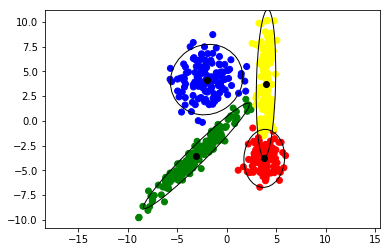

In [35]:
vizualise_ellipses(x, q.idxmax(1), mu, Sigma)

Compute the likelihood

In [39]:
z = q.idxmax(1)

In [40]:
x_test = EM_test
q_test = pd.DataFrame(0,index=x_test.index, columns=range(K))

denom = pd.Series(0,index=x_test.index)
for k in range(K):
    denom = denom + pi[k]*gauss(x_test,mu[k],Sigma[k],2)
        
for k in range(K):
    q_test[k] = pi[k]*gauss(x_test,mu[k],Sigma[k],2)/denom

z_test = q_test.idxmax(1)

In [41]:
log_likelihood(x,z,pi,mu,Sigma)

-2345.772138218651

In [42]:
log_likelihood(x_test,z_test,pi,mu,Sigma)

-2426.8234777657012